# Machine Learning: Classification

#### Student Intervention System

- The objective of this workbook is to walk through the process of utilizing Random Forest to predict the likelihood that a given student will pass, thus helping diagnose whether or not an intervention is necessary. The model is developed based on a subset of data that consists of information from randomly sample students, and it will be tested against a subset of the data that is kept hidden from the learning algorithm, in order to test the model’s effectiveness on data outside the training set.

In [753]:
#Python Version --> Python 3.5
import sys
print(sys.version)

3.5.2 |Anaconda 4.2.0 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


### Import libraries

In [754]:
import numpy as np
import pandas as pd
import csv
import time

#Scikit-Learn Machine Learning 
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split

import pylab as pl
import matplotlib.pyplot as pl
from sklearn.preprocessing import scale
from sklearn import metrics

#Seaborn 
pl.style.use('fivethirtyeight')
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [755]:
#Read in csv file into pandas dataframe
student_data = pd.read_csv("student-data.csv")
print ("Student data read successfully!")

Student data read successfully!


In [756]:
#return the first 5 rows (all columns)
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


In [757]:
X_all = student_data.iloc[:,1:-1]
y = student_data['passed']

In [758]:
print(student_data[student_data['passed'] == "no"].shape[0])
print(student_data[student_data['passed'] == "yes"].shape[0])
print(student_data.shape[0])

130
265
395


### Preprocess feature columns

In [759]:
def preprocess_features(X):
    df_preprocess = pd.DataFrame(index=X.index) # output dataframe, initially empty
    # iterate through each column
    for colname, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object: #if data type == object (i.e. non-numeric)
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # If data is non-numeric and consist of more than 2 level
        # convert todummy variables (indicator variables)
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=colname)  
        #join columns to one dataframe
        df_preprocess = df_preprocess.join(col_data)  # collect column(s) in output dataframe
    return df_preprocess

X_all = preprocess_features(X_all)
print("Processed Feature Columns")
X_all.head()

Processed Feature Columns


,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Medu,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1.0,0.0,18,0.0,1.0,1.0,0.0,1.0,0.0,4,...,1,0,0,4,3,4,1,1,3,6
1,1.0,0.0,17,0.0,1.0,1.0,0.0,0.0,1.0,1,...,1,1,0,5,3,3,1,1,3,4
2,1.0,0.0,15,0.0,1.0,0.0,1.0,0.0,1.0,1,...,1,1,0,4,3,2,2,3,3,10
3,1.0,0.0,15,0.0,1.0,1.0,0.0,0.0,1.0,4,...,1,1,1,3,2,2,1,1,5,2
4,1.0,0.0,16,0.0,1.0,1.0,0.0,0.0,1.0,3,...,1,0,0,4,3,2,1,2,5,4


In [760]:
df = pd.concat([X_all, y], axis = 1)

### Split Data Into Training/Testing Sets

In [761]:
def Stratified_Shuffle_Split(X,y,num_test):
    sss = StratifiedShuffleSplit(y, 1, test_size=num_test, random_state = None)
    for train, test in sss:
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
    return X_train, X_test, y_train, y_test

y = student_data['passed'] # identify target variable
X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, 0.25)

print("Training Set: {0:.2f} Samples".format(X_train.shape[0]))
print("Testing Set: {0:.2f} Samples".format(X_test.shape[0]))

Training Set: 296.00 Samples
Testing Set: 99.00 Samples


### Generate Model (Random Forest)

In [762]:
def train_classifier(clf, X_train, y_train):
    start = time.time() #specifty start time
    clf.fit(X_train, y_train) #train model
    end = time.time() #specify end time
    train_clf_time = end - start #total training time
    print("Total Training Time (secs): {:.3f}".format(train_clf_time))
    return train_clf_time 

def predict_labels(clf, features, target):
    start = time.time() #start prediction time
    y_pred = clf.predict(features) #prediction 
    end = time.time() # stop prediction time
    prediction_time = end - start # total prediction time
    print("Prediction Time (secs): {:.3f}".format(prediction_time))
    
    p,r,f,s = precision_recall_fscore_support(target.values,
              y_pred, average='binary', pos_label='yes')
    print("Precision Score: {0:.4f}".format(p))
    print("Recall Score: {0:.4f}".format(r))
    print("F1 Score: {0:.4f}".format(f))
    return(f)

### Train and Predict

In [763]:
print("==============================")
print("Model: {}".format(clf.__class__.__name__))
print("==============================")
    
results = []
n_est = [10,50,100,200,300,400,500,600,800,1000]
for trees in n_est:
    
    clf = RandomForestClassifier(n_estimators = trees)
    print("**********************************************************")
    print("**Training**")
    print("Data Size:",len(X_train))

    # Fit model to training data
    train_classifier(clf, X_train, y_train)

    # Predict on training set and compute F1 score
    predict_labels(clf, X_train, y_train)

    #Predict on Testing Data
    print("**********************************************************")
    print("**Testing**")
    print("Data Size:",len(X_test))
    predict_labels(clf, X_test, y_test)
    f1 = predict_labels(clf, X_test, y_test)
    results.append(f1)
    print("**********************************************************")

    

Model: RandomForestClassifier
**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.012
Prediction Time (secs): 0.001
Precision Score: 0.9851
Recall Score: 0.9950
F1 Score: 0.9900
**********************************************************
**Testing**
Data Size: 99
Prediction Time (secs): 0.001
Precision Score: 0.7297
Recall Score: 0.8182
F1 Score: 0.7714
Prediction Time (secs): 0.001
Precision Score: 0.7297
Recall Score: 0.8182
F1 Score: 0.7714
**********************************************************
**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.055
Prediction Time (secs): 0.005
Precision Score: 1.0000
Recall Score: 1.0000
F1 Score: 1.0000
**********************************************************
**Testing**
Data Size: 99
Prediction Time (secs): 0.003
Precision Score: 0.7439
Recall Score: 0.9242
F1 Score: 0.8243
Prediction Time (secs): 0.004
Precision

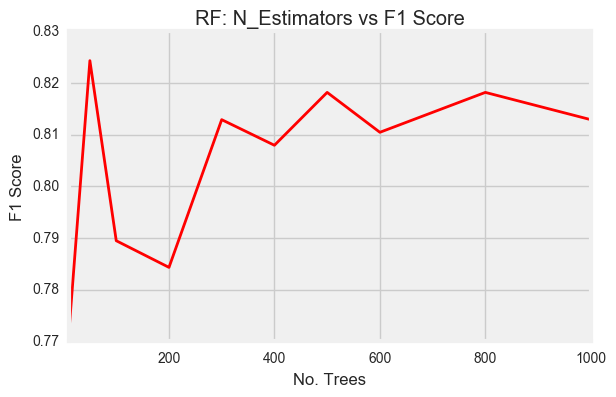

In [764]:
ax = pd.Series(results,n_est).plot(lw=2,color="red",
             title="RF: N_Estimators vs F1 Score")
ax.set_xlabel("No. Trees")
ax.set_ylabel("F1 Score")

In [765]:
df.head()

,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Medu,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,1.0,0.0,18,0.0,1.0,1.0,0.0,1.0,0.0,4,...,0,0,4,3,4,1,1,3,6,no
1,1.0,0.0,17,0.0,1.0,1.0,0.0,0.0,1.0,1,...,1,0,5,3,3,1,1,3,4,no
2,1.0,0.0,15,0.0,1.0,0.0,1.0,0.0,1.0,1,...,1,0,4,3,2,2,3,3,10,yes
3,1.0,0.0,15,0.0,1.0,1.0,0.0,0.0,1.0,4,...,1,1,3,2,2,1,1,5,2,yes
4,1.0,0.0,16,0.0,1.0,1.0,0.0,0.0,1.0,3,...,0,0,4,3,2,1,2,5,4,yes


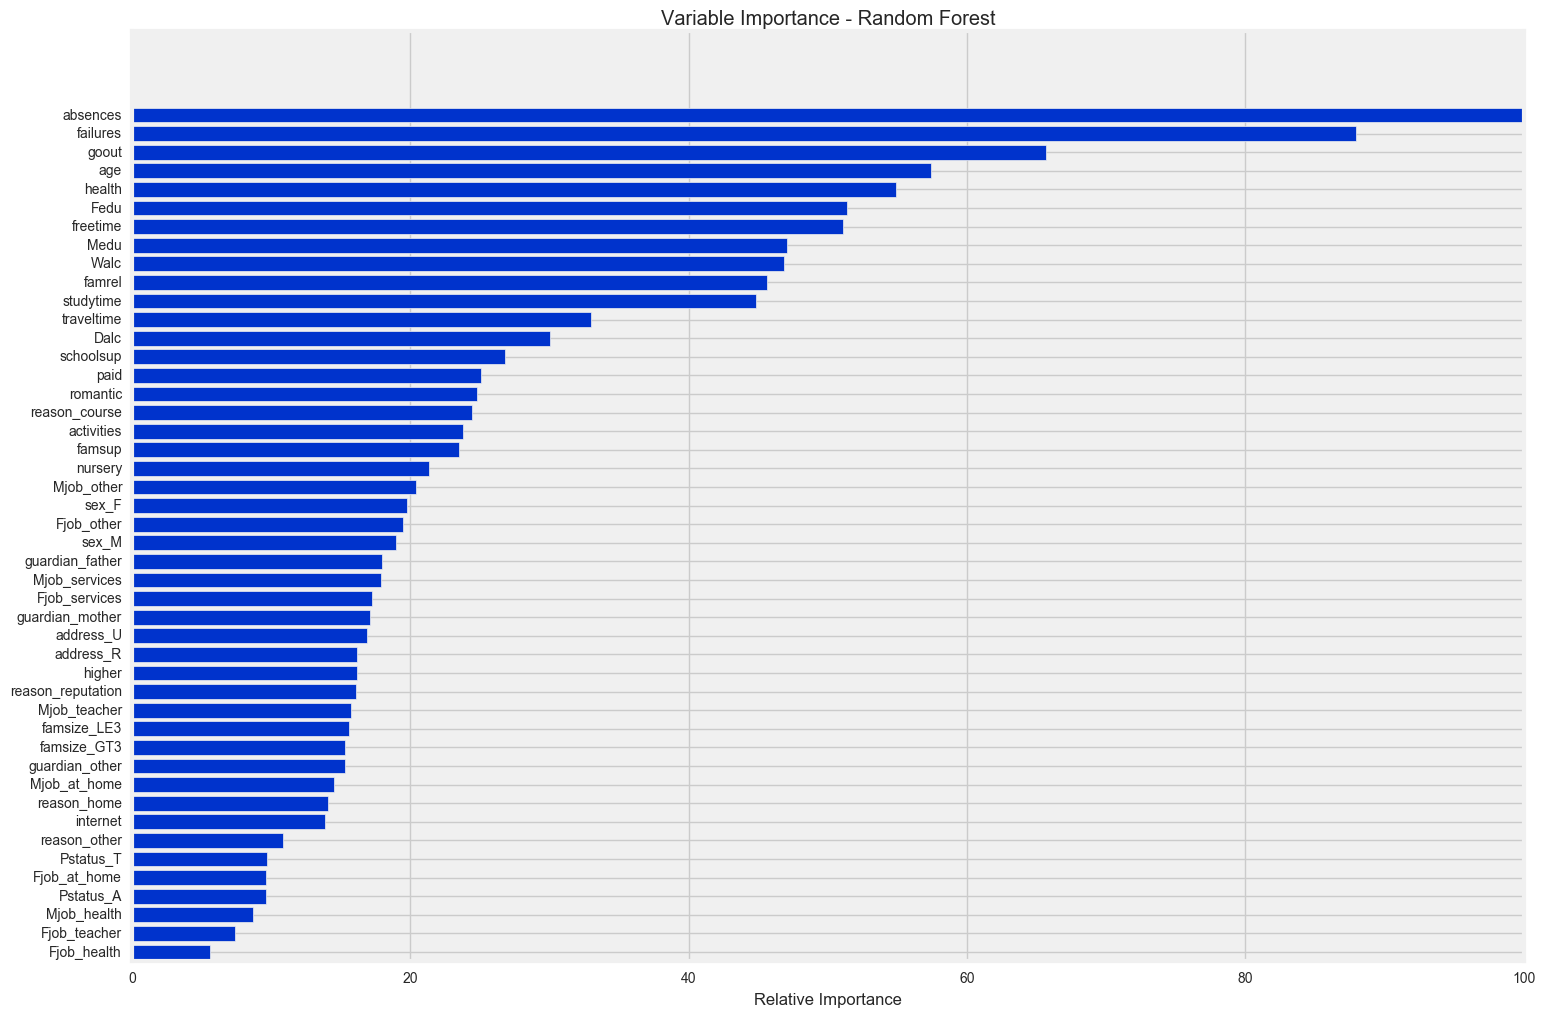

In [767]:
#Feature Selection 
def feature_importance(clf,df):
    
    # Relative Importance (Features)
    clf.fit(X_train,y_train)
    
    # Get Feature Importance from the classifier
    feature_importance = clf.feature_importances_
    
    # Normalize The Features
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    
    # Sort Features and Creat Horizontal Bar Plot
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    pl.figure(figsize=(16, 12))
    pl.barh(pos, feature_importance[sorted_idx], align='center', color='#0033CC')
    pl.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
    pl.xlabel("Relative Importance")
    pl.title("Variable Importance - Random Forest")
    pl.show()

feature_importance(clf,df)

### Feature Selection

In [770]:
from sklearn.feature_selection import VarianceThreshold
 
def get_low_variance(X_all,threshold):
   
    selector = VarianceThreshold()
    selector.fit(X_all)
    
    index = selector.variances_ > threshold
    filt = [i for i, x in enumerate(index) if x]
    
    X_all_filt = X_all.iloc[:,filt]
    
    print("Max Variance: {0:.3f}".format(max(selector.variances_)))
    print("Min Variance: {0:.3f}".format(min(selector.variances_)))
    print("Median Variance: {0:.3f}".format(np.median(selector.variances_)))
    
    x = []
    for i in selector.variances_:
        if i < 1:
            x.append(i)
    plt.hist(x,bins=10)
    
    print("\n**Total Number of Features Removed: {}**".format(
                X_all.shape[1]-X_all_filt.shape[1]))
    print("**Total Number of Features:{}".format(X_all_filt.shape[1]))
    return(X_all_filt)

Max Variance: 63.887
Min Variance: 0.043
Median Variance: 0.209

**Total Number of Features Removed: 3**
**Total Number of Features:43


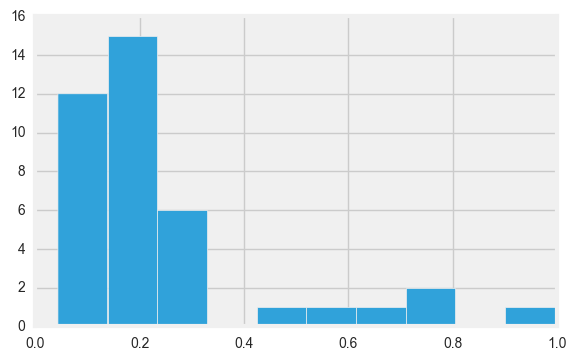

In [771]:
X_all = get_low_variance(X_all,0.05)

In [772]:
X_all.head()

,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Medu,...,nursery,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1.0,0.0,18,0.0,1.0,1.0,0.0,1.0,0.0,4,...,1,0,0,4,3,4,1,1,3,6
1,1.0,0.0,17,0.0,1.0,1.0,0.0,0.0,1.0,1,...,0,1,0,5,3,3,1,1,3,4
2,1.0,0.0,15,0.0,1.0,0.0,1.0,0.0,1.0,1,...,1,1,0,4,3,2,2,3,3,10
3,1.0,0.0,15,0.0,1.0,1.0,0.0,0.0,1.0,4,...,1,1,1,3,2,2,1,1,5,2
4,1.0,0.0,16,0.0,1.0,1.0,0.0,0.0,1.0,3,...,1,0,0,4,3,2,1,2,5,4


### Tunning Random Forest Model

In [773]:
# Reformat the Target Column to 1 and 0....pass if already executed code block
try: # try replacing yes and no with 1 and 0.
    y = y.replace(['yes', 'no'], [1, 0])
except:
    pass # pass

In [799]:
def random_forest_tune(X_train,X_test,y_train,y_test):
    start = time.time()
    
    clf = RandomForestClassifier()
    X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)

    parameters = {'n_estimators':list(range(50,100))},

    clf = GridSearchCV(clf, parameters, scoring = 'f1')

    # Fit the learner to the training data to obtain the best parameter set
    clf.fit(X_train, y_train)
    f1_scores.append(clf.score(X_test, y_test))
    
    pred = clf.predict(X_test)
   
    #Prediction Probability:
    p = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, p ,pos_label=1)
    
    #print("AUC: {0:.4f}".format(metrics.roc_auc_score(y_test,p)))
    
    #Plot True Positive and False Positive Rate
    plt.plot(fpr,tpr,linewidth=1.5)
    plt.plot([0,1],[0,1],'k-',linewidth=1.5)
    plt.title("Random Forest - ROC ")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()
   
    f1_score_test = round(f1_score(y_test, pred, average='weighted'),3) #f1 score
    auc_score = metrics.roc_auc_score(y_test,p)
    end = time.time()
    total_time = end-start
    m,s = divmod(total_time,60)
    h,m = divmod(m,60)
    time_format = "%d:%02d:%02d" % (h,m,s)
    
    return(f1_score_test, auc_score, clf.best_params_['n_estimators'],
           clf.best_params_,time_format,
           pred,y_test,)

Iterating......

Loop: 1


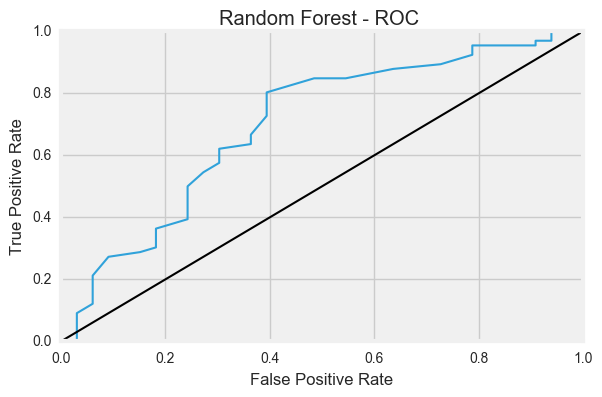

Best Parameters:
{'n_estimators': 94}
Total Run Time: 0:00:11

Loop: 2


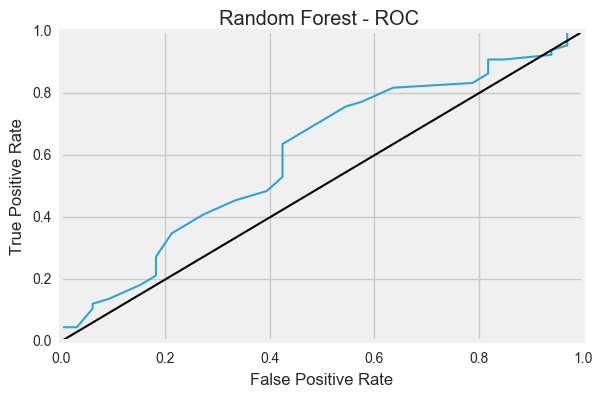

Best Parameters:
{'n_estimators': 50}
Total Run Time: 0:00:11

Loop: 3


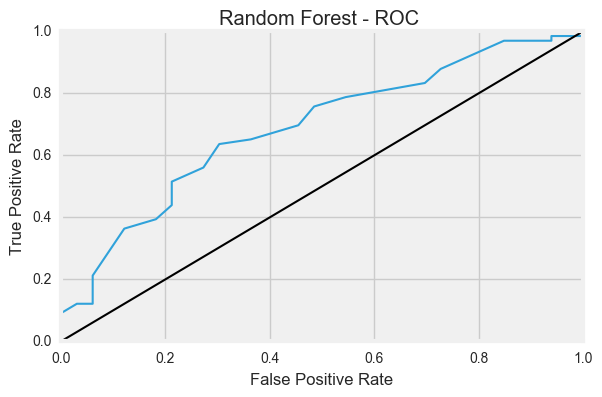

Best Parameters:
{'n_estimators': 51}
Total Run Time: 0:00:11

Loop: 4


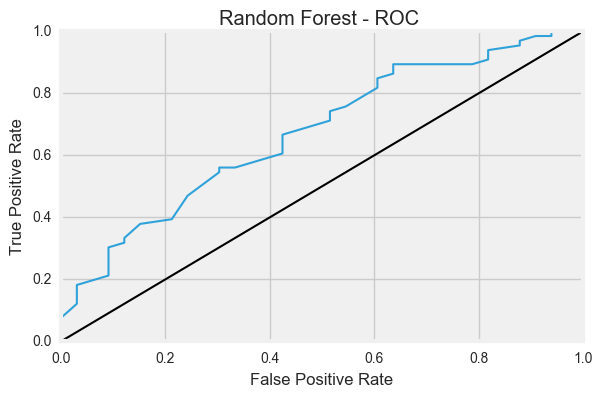

Best Parameters:
{'n_estimators': 97}
Total Run Time: 0:00:12

Loop: 5


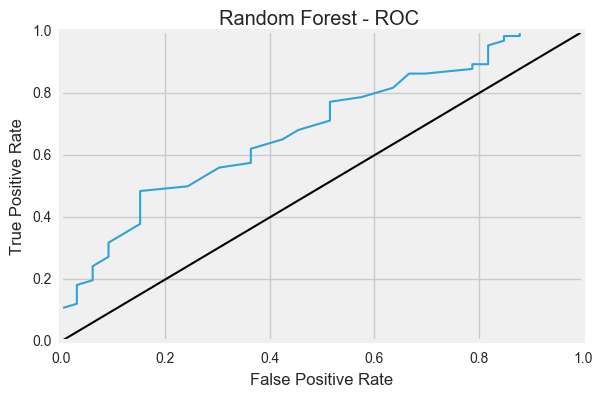

Best Parameters:
{'n_estimators': 79}
Total Run Time: 0:00:12

Loop: 6


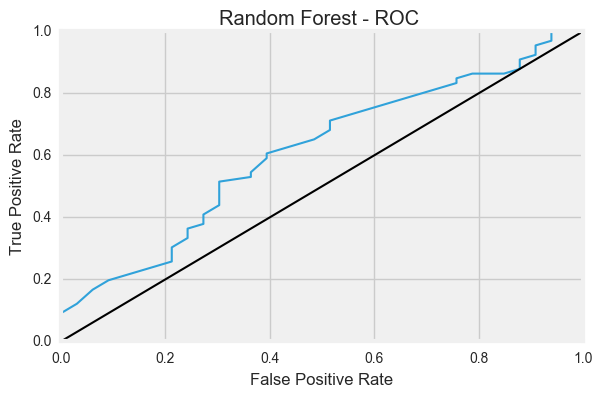

Best Parameters:
{'n_estimators': 77}
Total Run Time: 0:00:12

Loop: 7


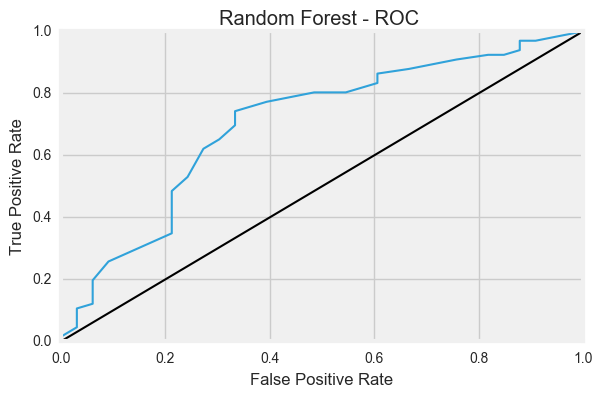

Best Parameters:
{'n_estimators': 59}
Total Run Time: 0:00:12

Loop: 8


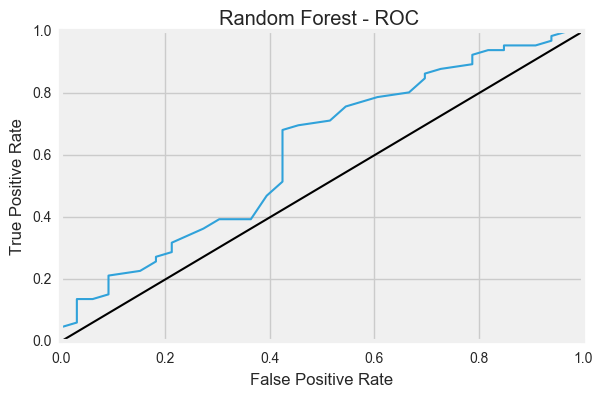

Best Parameters:
{'n_estimators': 83}
Total Run Time: 0:00:12

Loop: 9


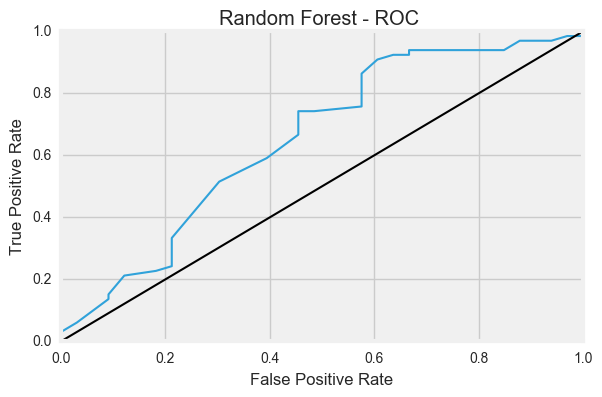

Best Parameters:
{'n_estimators': 56}
Total Run Time: 0:00:12

Loop: 10


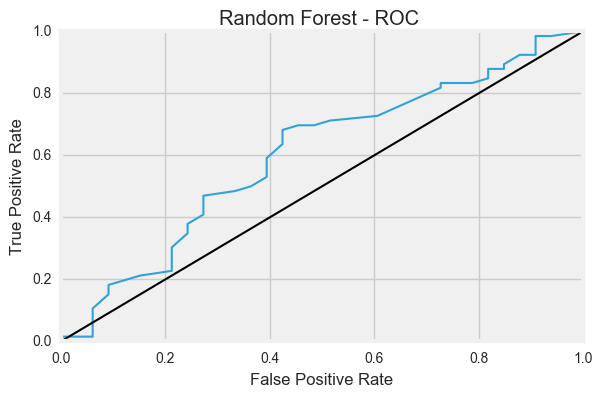

Best Parameters:
{'n_estimators': 89}
Total Run Time: 0:00:12
------------------------------
          SUMMARY             
------------------------------

Results from iteration:
   F1 Score  AUC Score  n_estimators Total Run Time
0     0.797   0.697888          94.0        0:00:11
1     0.760   0.602158          50.0        0:00:11
2     0.795   0.688476          51.0        0:00:11
3     0.784   0.671717          97.0        0:00:12
4     0.776   0.684573          79.0        0:00:12
5     0.755   0.610193          77.0        0:00:12
6     0.795   0.701102          59.0        0:00:12
7     0.784   0.613407          83.0        0:00:12
8     0.819   0.651515          56.0        0:00:12
9     0.763   0.600551          89.0        0:00:12

Average results:
F1 Score         0.782800
AUC Score        0.652158
n_estimators    73.500000
dtype: float64


In [801]:
GridSearchResults = pd.DataFrame(columns = ['F1 Score','AUC Score',
                                                'n_estimators',
                                                 'Total Run Time'])
print("Iterating......")
for i in range(0,10):
    print("\nLoop: {}".format(i+1))
    x = random_forest_tune(X_train,X_test,y_train,y_test)
    print("Best Parameters:\n{}".format(x[3]))
    print("Total Run Time: {}".format(x[4]))
    GridSearchResults = GridSearchResults.append({
            'F1 Score': x[0],
            'AUC Score':x[1],
            'n_estimators':x[2],
            'Total Run Time': x[4]},ignore_index=True)
    
print("------------------------------")
print("          SUMMARY             ")
print("------------------------------")
print("\nResults from iteration:")    
print(GridSearchResults)
print("\nAverage results:")
print(GridSearchResults.mean())

In [802]:
#Comparing Predicted vs True
print("Predicted: {}".format(y_predicted2[0:10]))
print("True Values: {}".format(y_test2[0:10]))

Predicted: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
True Values: [1, 1, 1, 0, 1, 0, 1, 1, 1, 0]


### Confusion Matirx

In [545]:
#set y_true = y_test and y_pred to clf.predict()
y_true, y_pred = y_test, clf.predict(X_test)

#Target Names
labels = ["failed","passed"]

#Classification report: 
print(classification_report(y_true, y_pred,target_names=labels))    

             precision    recall  f1-score   support

     failed       0.64      0.21      0.32        33
     passed       0.70      0.94      0.81        66

avg / total       0.68      0.70      0.64        99



In [546]:
# Print Conf_Matrix
conf_matrix = pd.crosstab(y_true, y_pred, colnames=['Predicted:'], margins=True)
print("Confusion Matrix:\n", conf_matrix)
            
#Normalize Conf_Matrix:
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)
print("\nNormalized Confusion Matrix: \n", conf_matrix_norm)

Confusion Matrix:
 Predicted:  no  yes  All
passed                  
no           7   26   33
yes          4   62   66
All         11   88   99

Normalized Confusion Matrix: 
 Predicted:        no       yes       All
passed                                  
no          0.106061  0.196970  0.166667
yes         0.060606  0.469697  0.333333
All         0.166667  0.666667  0.500000


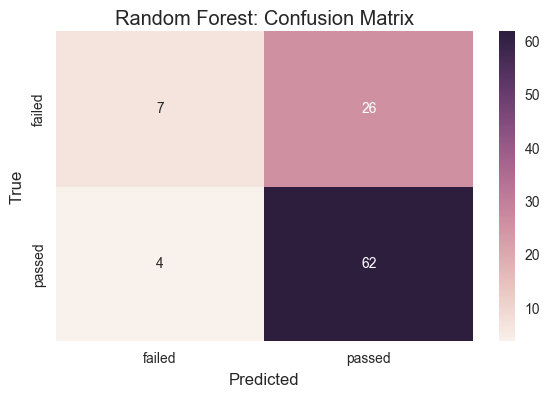

In [547]:
#Generate Confusion Matrix Plot
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
pl.title('Random Forest: Confusion Matrix')
sns.heatmap(conf_matrix, xticklabels=labels,yticklabels=labels, annot=True, fmt='')
pl.xlabel("Predicted")
pl.ylabel("True")

### Out of Bounds Error Rate

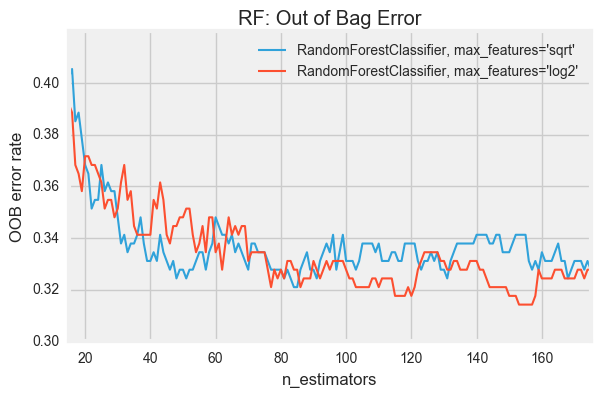

In [955]:
from collections import OrderedDict

#Number of Trees
min_estimators = 15
max_estimators = 175

ensemble_rf = [
    #Max_features = "sqrt"
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, 
                               oob_score=True,
                               max_features="sqrt",
                               random_state=42)),
    #Max_features = "log2"
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, 
                               max_features='log2',
                               oob_score=True,
                               random_state=42))]

# Map a classifier name to a list containing n_estimators & error rate
error_rate = OrderedDict((name, list()) for name, _ in ensemble_rf)

#iterate for every name and clf in list for ensemble of RF models
for name, clf in ensemble_rf:
    #iterate from the min number of trees to max
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        #train the model
        clf.fit(X_train, y_train)
        #combute the out of bag error rate of the held out set
        oob_error = 1 - clf.oob_score_
        #append list in dictionary for key 'name'
        error_rate[name].append((i, oob_error))

for label, clf_err in error_rate.items():
    #zip clf_err --> (tree_num, error)
    x, y = zip(*clf_err)
    plt.plot(x, y, label=label,linewidth=1.5)
    
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.title("RF: Out of Bag Error")
plt.show()